# Pepper pot hole size investigation
This notebook contains simulations of a pepperpot emittance meter in order to determine how the hole size affects the reconstructed emittance value

In [5]:
### Import statements
import numpy as np
import matplotlib.pyplot as plt
import pepper # This module containts the pepperpot simulator and some plotting functions

# a little plotting helper
def plot_conf_band(ax, x, y, ystd, level=3, label=None):
    ax.plot(x, y, label=label)
    ax.fill_between(x, y - level*ystd, y + level*ystd, alpha=.5)

## An example
We start with an example to demonstrate the model and tha phase space reconstruction with a pepperpot

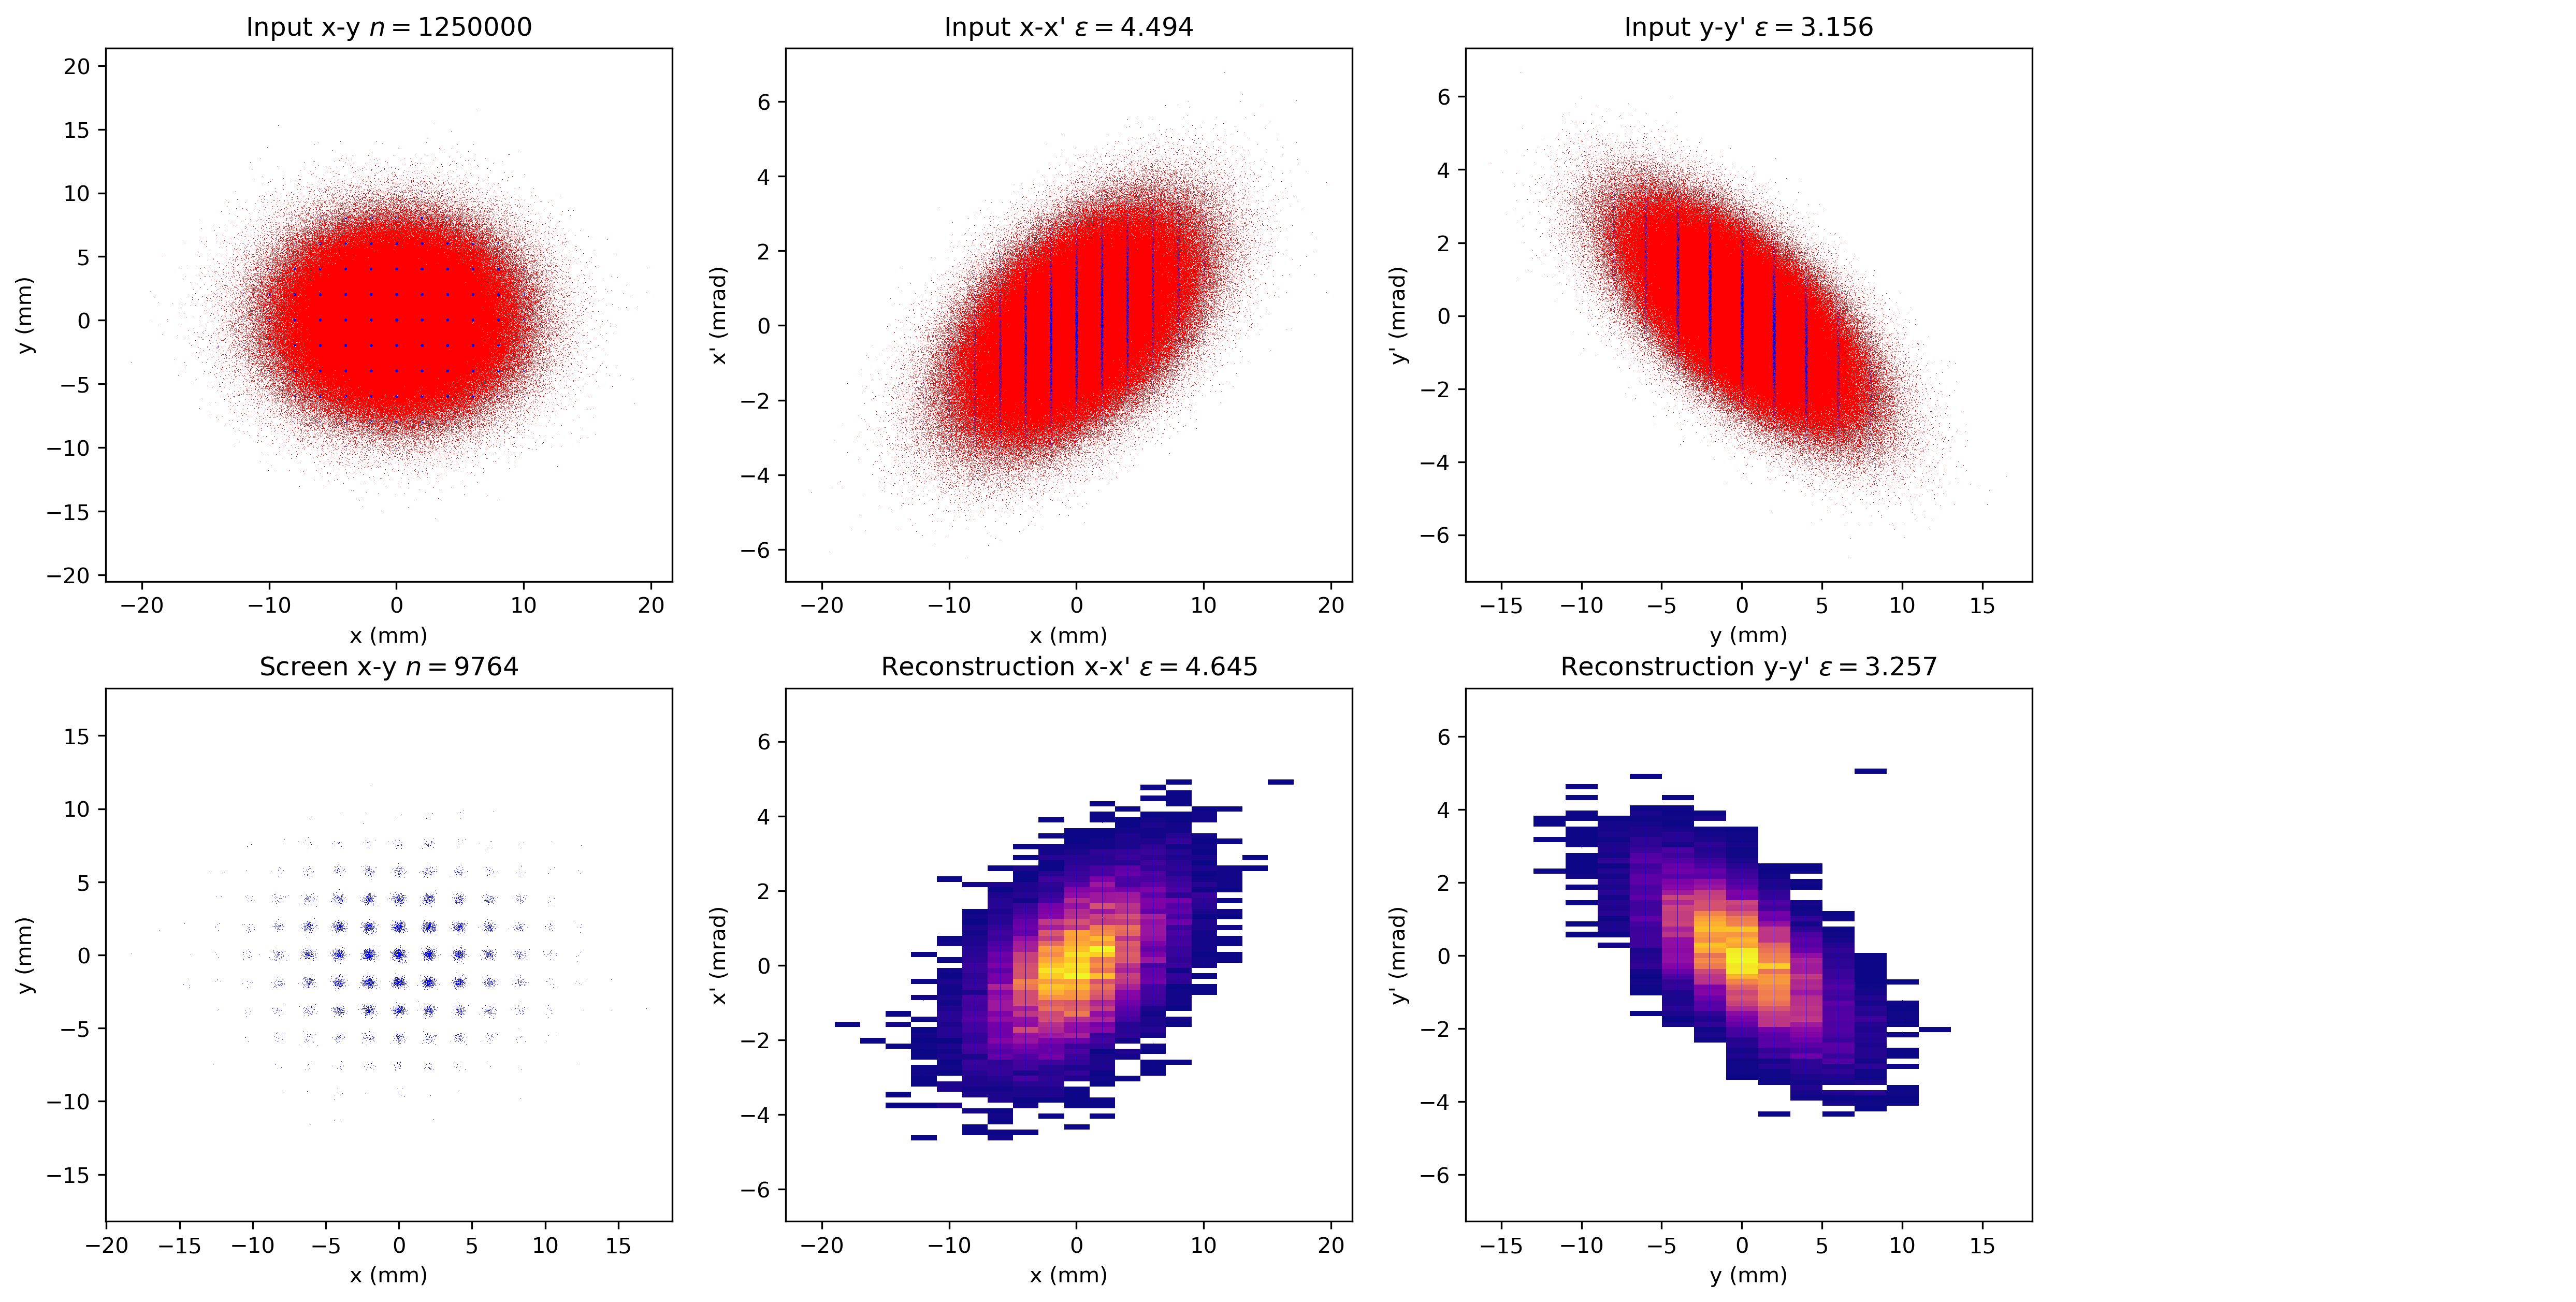

In [2]:
### Parameters for the demonstration
n = 1250000 #num particles before mask
sigx = 4.0 # beamsize at mask in mm
sigxp = 1.3 # divergence of beam in mrad
emitx = 4.5 # emittance in mm mrad

### Create a pepperpot with standard parameters d=2, r=0.1, l=190, n=51
pot = pepper.Pepperpot()
# generate a slightly elliptical beam
beam = pepper.generate_gaussian_beam_2D(n, sigx, sigxp, emitx, .8*sigx, sigxp, 0.7*emitx)
# focus y instead of defocusing
beam["yp"] = -beam["yp"] 
# simulate the measurement
meas = pot.measure(beam)
# and generate a nice visualtisation
pot.visualise_measurement(meas)

## Hole size studies
We can see (plot titles) that there is a deviation between the actual emittance and the one reconstructed through the pepperpot.
One contribution to this is the finite holesize of the mask which introduces angular errors in the phase space reconstruction.
Let us define a function that helps us to study this effect systematically.

This function takes a beamgenerator (which returns a particle distribution each time it is called) to create a dstribution to be simulated. The emittance of this distribution is calculated and then "measured" with pepperpots of varying holesize. Fpr each holesize this is done repeatedly with new beams (samples) to account for statistical fluctuations.
Then a plot is created visualising the results.

In [6]:
def hole_size_scan(smallest, largest, steps, samples, beamgenerator):
    # Create an array of steps to take (hole radius)
    sizes = np.linspace(smallest, largest, steps)
    
    # Allocate some arrays for the results
    emit_stat_x = np.zeros((steps, samples))
    emit_meas_x = np.zeros((steps, samples))
    emit_stat_y = np.zeros((steps, samples))
    emit_meas_y = np.zeros((steps, samples))
    
    # Loop through all holesizes
    for ii, hs in enumerate(sizes):
        #Create a pepperpot with a suitable holesize
        pot = pepper.Pepperpot(r = hs)
        
        # And repeat as often as wished
        for jj in range(samples):
            # Create a beam using the generator passed by the user
            beam = beamgenerator()
  
            res = pot.measure(beam)
 
            emit_stat_x[ii, jj] = res["emit_inp_x"]
            emit_stat_y[ii, jj] = res["emit_inp_y"]
            emit_meas_x[ii, jj] = res["emit_rec_x"]
            emit_meas_y[ii, jj] = res["emit_rec_y"]
    
    es_x_m = emit_stat_x.mean(1)
    es_y_m = emit_stat_y.mean(1)
    es_x_s = emit_stat_x.std(1)
    es_y_s = emit_stat_y.std(1)
    em_x_m = emit_meas_x.mean(1)
    em_y_m = emit_meas_y.mean(1)
    em_x_s = emit_meas_x.std(1)
    em_y_s = emit_meas_y.std(1)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,10), dpi=300)
    plot_conf_band(axs[0], sizes, es_x_m, es_x_s, label="stat")
    plot_conf_band(axs[0], sizes, em_x_m, em_x_s, label="meas")
    plot_conf_band(axs[1], sizes, es_y_m, es_y_s, label="stat")
    plot_conf_band(axs[1], sizes, em_y_m, em_y_s, label="meas")
    plt.legend()
    plt.show()

Now we can test the function

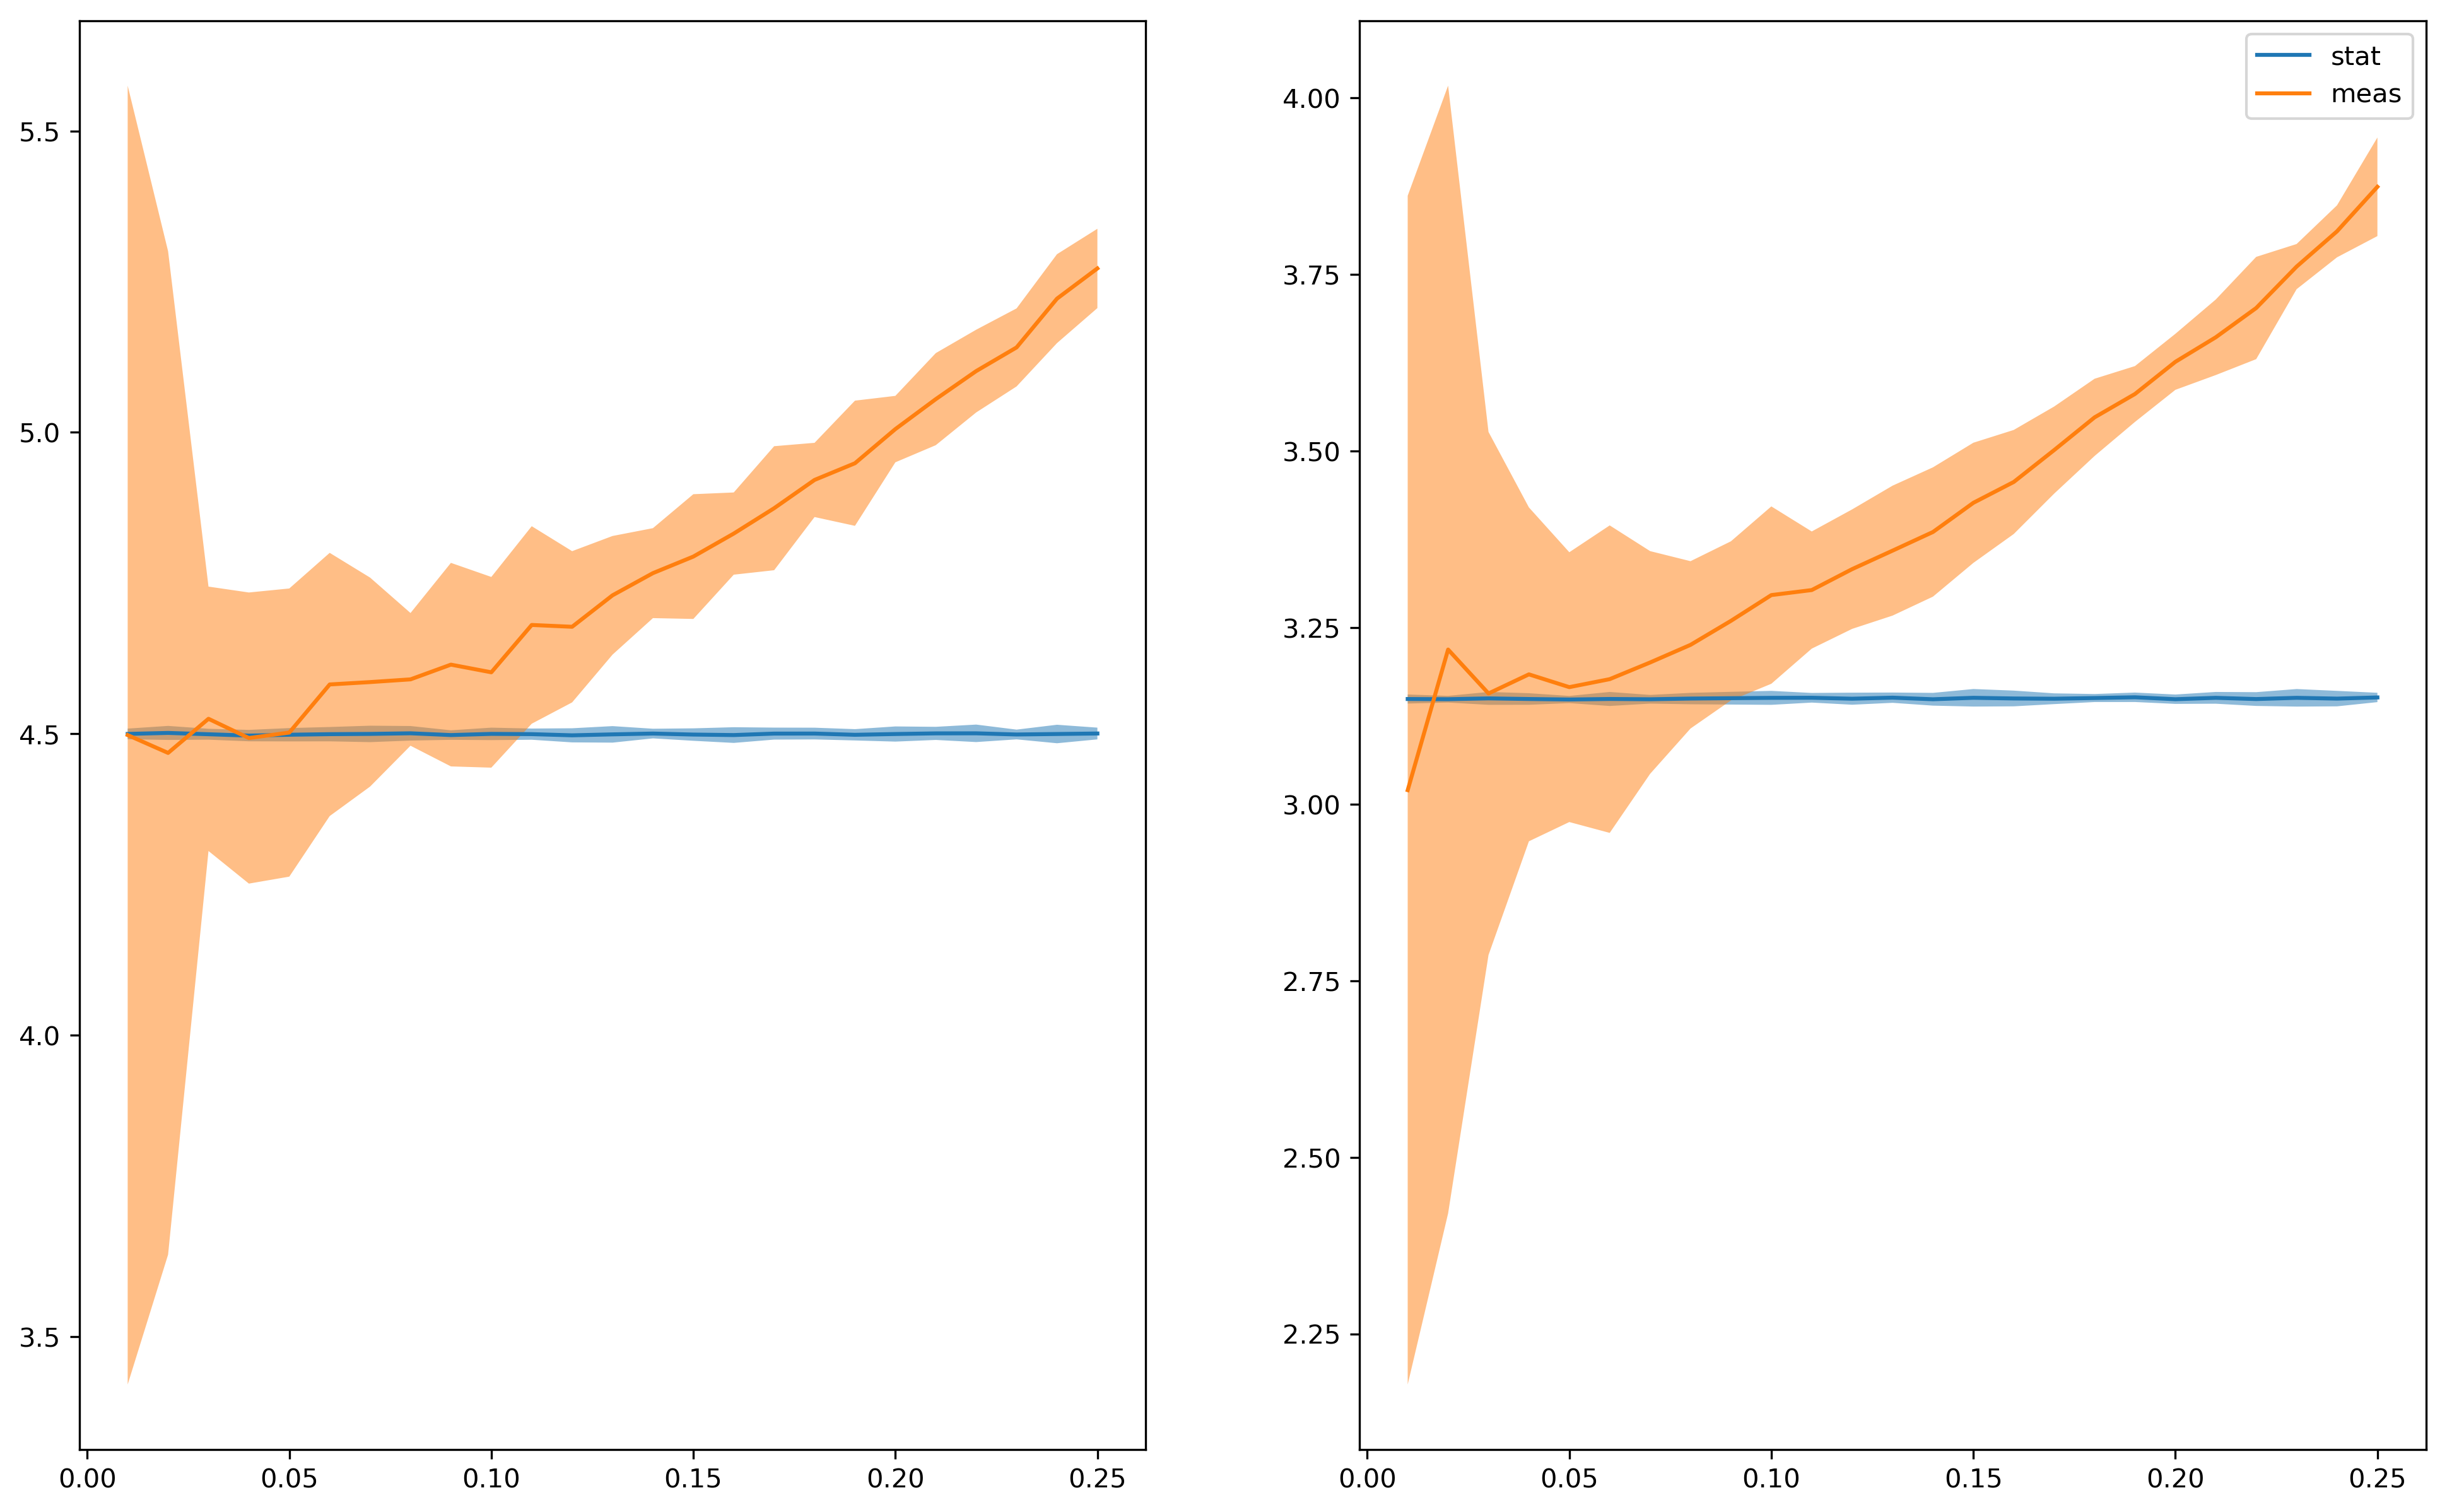

In [9]:
### This beamgenerator will return the same kind of beam as in the example shown above
n = 1250000 #num particles before mask
sigx = 4.0 # beamsize at mask in mm
sigxp = 1.3 # divergence of beam in mrad
emitx = 4.5 # emittance in mm mrad
beamgenerator = lambda: pepper.generate_gaussian_beam_2D(n, sigx, sigxp, emitx, .8*sigx, sigxp, 0.7*emitx)

### Scan parameters
smallest = 0.01 #mm
largest = 0.25 #mm
steps = 25
samples = 10
hole_size_scan(smallest, largest, steps, samples, beamgenerator)

In [ ]:
def emittance_scan():
    pot = Pepperpot()
    sigx = 5
    sigxps = np.linspace(.0e-3, 1.0e-3, 25)
    Nsample = 1
    N = 1250000
    emit_theo_x = np.zeros((len(sigxps), 1))
    emit_stat_x = np.zeros((len(sigxps), Nsample))
    emit_meas_x = np.zeros((len(sigxps), Nsample))
    emit_theo_y = np.zeros((len(sigxps), 1))
    emit_stat_y = np.zeros((len(sigxps), Nsample))
    emit_meas_y = np.zeros((len(sigxps), Nsample))

    for ii, sigxp in enumerate(sigxps):
        sigy = 0.8 * sigx
        sigyp = 1.3
        emit_theo_x[ii] = sigx*sigxp
        emit_theo_y[ii] = sigy*sigyp
        for jj in range(Nsample):
            print("ii =", ii, "jj =", jj)
            x = np.random.normal(0, sigx, N)
            xp = np.random.normal(0, sigxp, N)
            y = np.random.normal(0, sigy, N)
            yp = -np.random.normal(0, sigyp, N)
            p = {"x":x, "y":y, "xp":xp, "yp":yp}

            res = pot.measurement(p)

            emit_stat_x[ii, jj] = res["emit_inp_x"]
            emit_stat_y[ii, jj] = res["emit_inp_y"]
            emit_meas_x[ii, jj] = res["emit_rec_x"]
            emit_meas_y[ii, jj] = res["emit_rec_y"]

    return emit_theo_x, emit_stat_x, emit_meas_x, emit_theo_y, emit_stat_y, emit_meas_y

emit_theo_x, emit_stat_x, emit_meas_x, emit_theo_y, emit_stat_y, emit_meas_y = emittance_scan()

plt.figure()
plt.plot(np.linspace(.0, 0.50e-3, 25), emit_stat_x.mean(1))
plt.fill_between(np.linspace(.0, 0.50e-3, 25), emit_stat_x.mean(1)-emit_stat_x.std(1)*3, emit_stat_x.mean(1)+emit_stat_x.std(1)*3, alpha=.4)
plt.plot(np.linspace(.0, 0.50e-3, 25), emit_meas_x.mean(1))
plt.fill_between(np.linspace(.0, 0.50e-3, 25), emit_meas_x.mean(1)-emit_meas_x.std(1)*3, emit_meas_x.mean(1)+emit_meas_x.std(1)*3, alpha=.4)
plt.show()

plt.figure()
plt.plot(np.linspace(.0, 0.50e-3, 25), emit_meas_x.mean(1)/emit_stat_x.mean(1))
plt.show()